# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [ ]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cpu


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [4]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

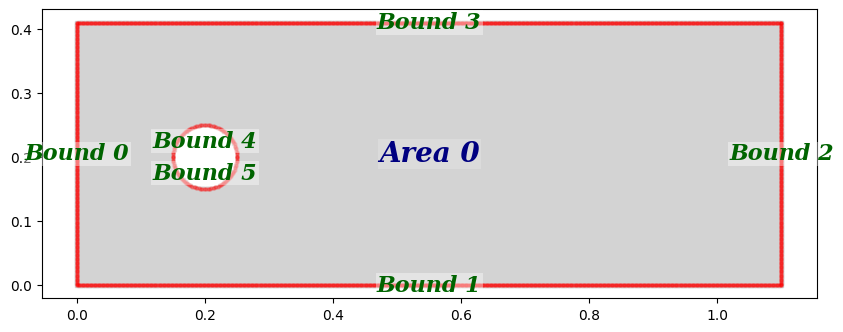

In [5]:
domain = df.domain(rectangle.bound_list, circle.bound_list, area)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

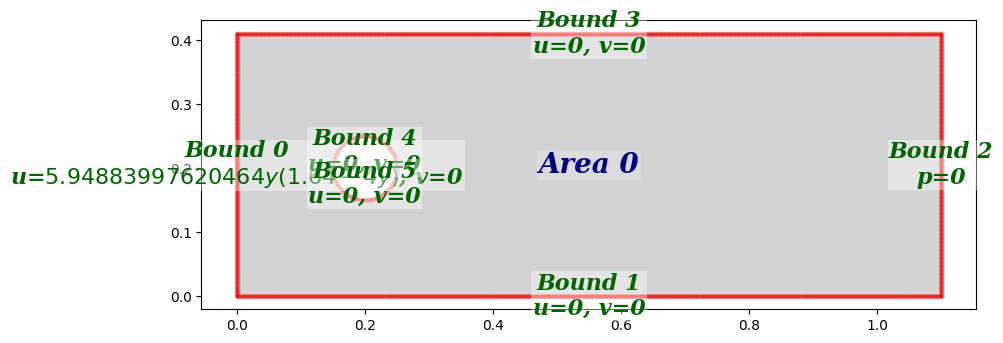

In [7]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

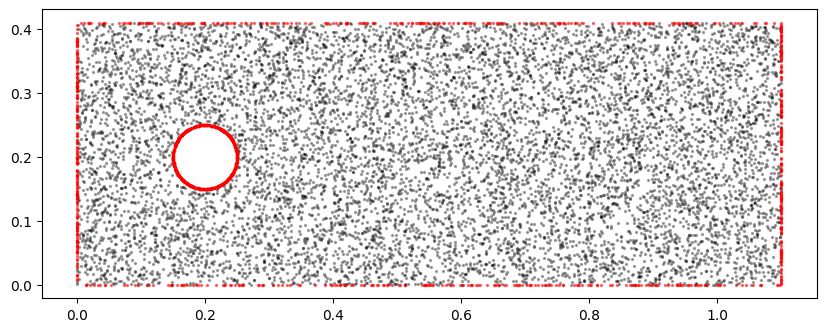

In [10]:
domain.sampling_random(bound_sampling_res=[200, 200, 200, 200, 400, 400])
domain.sampling_random(area_sampling_res=[10000])
domain.show_coordinates(display_conditions=False)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [11]:
model0 = df.PINN(width=50, length=5)

Design how to compute loss from boundary conditions and PDE residuals

In [ ]:
# Define the loss calculation function
def calc_loss(model):
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [ ]:
# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.001,
    epochs=2000,
    calc_loss=calc_loss,
    print_every=200,
    threshold_loss=0.001
)

epoch 1, total_loss: 0.60771, bc_loss: 0.59420, pde_loss: 0.00014
epoch 201, total_loss: 0.35887, bc_loss: 0.35514, pde_loss: 0.00004
epoch 401, total_loss: 0.33382, bc_loss: 0.32465, pde_loss: 0.00009
epoch 601, total_loss: 0.32687, bc_loss: 0.31737, pde_loss: 0.00009
epoch 801, total_loss: 0.32016, bc_loss: 0.31431, pde_loss: 0.00006
epoch 1001, total_loss: 0.31790, bc_loss: 0.31341, pde_loss: 0.00004
epoch 1201, total_loss: 0.31665, bc_loss: 0.31327, pde_loss: 0.00003
epoch 1401, total_loss: 0.31574, bc_loss: 0.31290, pde_loss: 0.00003
epoch 1601, total_loss: 0.31627, bc_loss: 0.31300, pde_loss: 0.00003
epoch 1801, total_loss: 0.31409, bc_loss: 0.31129, pde_loss: 0.00003
Final learning rate: 0.001


Refine the model using LBFGS for higher precision.

In [ ]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=calc_loss,
    epochs=500,
    print_every=50,
    threshold_loss=0.00001,
)

epoch 2001, total_loss: 0.28727, bc_loss: 0.27000, pde_loss: 0.01727
epoch 2051, total_loss: 0.11160, bc_loss: 0.09136, pde_loss: 0.02024
epoch 2101, total_loss: 0.02791, bc_loss: 0.01310, pde_loss: 0.01481
epoch 2151, total_loss: 0.00884, bc_loss: 0.00290, pde_loss: 0.00595
epoch 2201, total_loss: 0.00370, bc_loss: 0.00086, pde_loss: 0.00283
epoch 2251, total_loss: 0.00216, bc_loss: 0.00054, pde_loss: 0.00162
epoch 2301, total_loss: 0.00148, bc_loss: 0.00039, pde_loss: 0.00109
epoch 2351, total_loss: 0.00103, bc_loss: 0.00025, pde_loss: 0.00077
epoch 2401, total_loss: 0.00074, bc_loss: 0.00021, pde_loss: 0.00053
epoch 2451, total_loss: 0.00059, bc_loss: 0.00017, pde_loss: 0.00041


Save or Load the model for later use

In [11]:
import pickle
# # Save model with pickle
# with open("model2.pkl", "wb") as f:
#     pickle.dump(model2, f)

# Load model back
# with open("model2.pkl", "rb") as f:
#     model2 = pickle.load(f)

## 4. Visualization

### 4.1 Visualize area

In [ ]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area(300, 200)

NameError: name 'model2' is not defined

In [ ]:
area_eval["velocity magnitude"] = (area_eval["u"]**2 + area_eval["v"]**2)**0.5

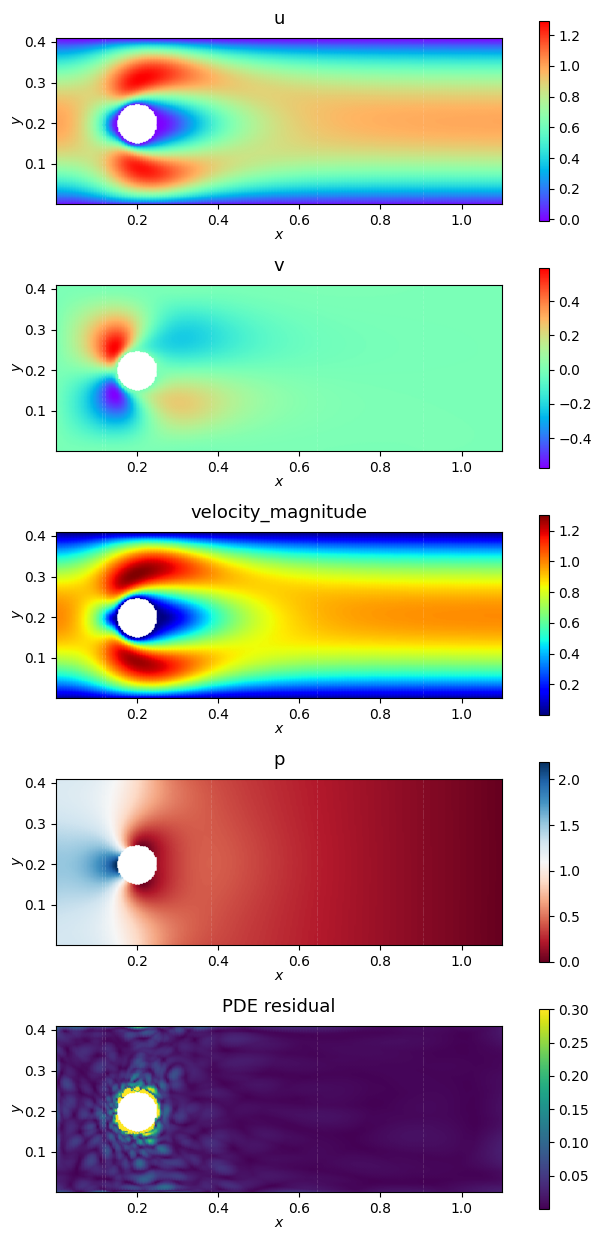

In [ ]:
cmap_dict = {
    'u':'rainbow',
    'v':'rainbow',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=0.5).savefig("colorplot_2d")

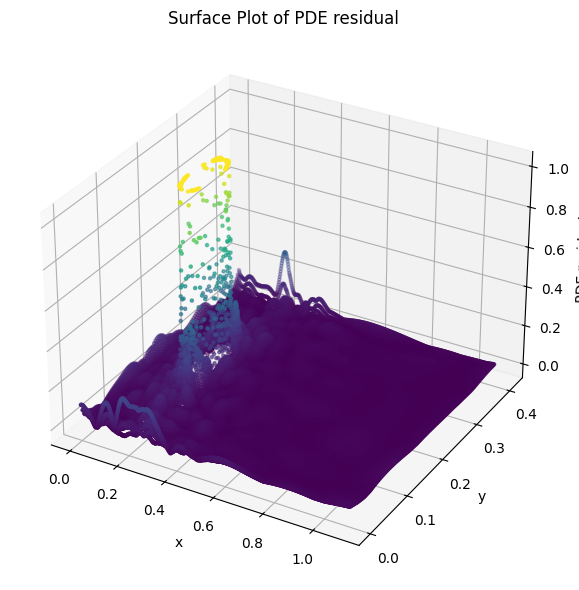

In [ ]:
residual_plot_3d = area_eval.plot('PDE residual').savefig("residual_plot_3d.png")

### 4.2 Visualize bound

In [ ]:
# Create object for evaluation
bound_visual = domain.bound_list[3].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(200)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


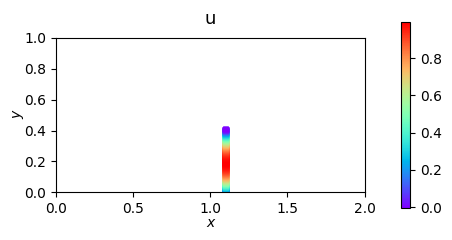

In [ ]:
colorplot_bound = bound_visual.plot_color({'u':'rainbow'}).savefig("colorplot_bound.png")

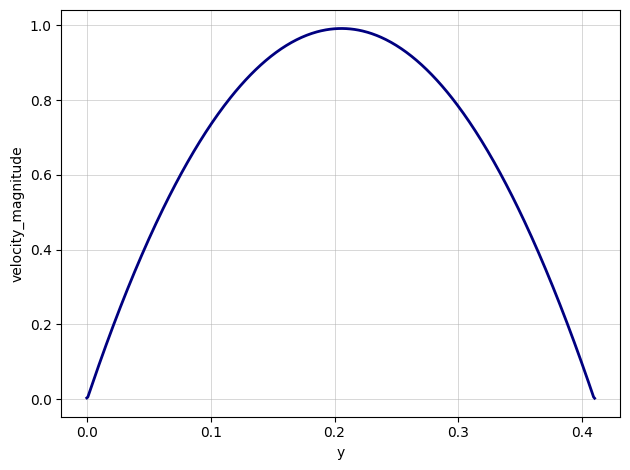

0.27169764


In [ ]:
velocity_plot_outlet = bound_visual.plot({'u'}, axis='y').savefig("plot_outlet_velocity.png")

## 4.3 Visualize Neural Network data

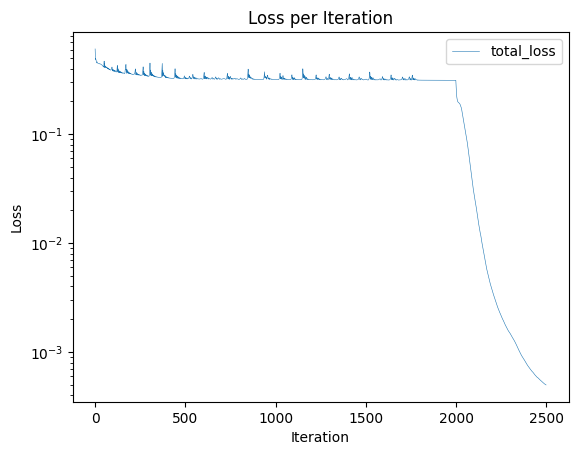

In [ ]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4).savefig("loss_history.png")

### 4.4 Export data

In [ ]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)